## 1.Importing Libs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

using GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2.Building custom DataSet

In [ ]:
class CustomMNISTDataSet(Dataset):
    def __init__(self,csv_file,transform=None,is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        item  = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28,28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28,28).astype(np.uint8)
            label = item.iloc[0]
        image = transforms.ToPILImage()(image)
        if self.transform is not None:
            image = self.transform(image)
        if self.is_test:
            return image
        else :
            return image,label 


applying some transformations and normalization

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) , (0.5,))
    ]
)

## 3.Splitting data into trian val test

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("train.csv")

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

In [ ]:
train_data_set = CustomMNISTDataSet(
    csv_file="train_split.csv", transform=transform, is_test=False
)
val_data_set = CustomMNISTDataSet(
    csv_file="val_split.csv", transform=transform, is_test=False
)
test_data_set = CustomMNISTDataSet(
    csv_file="test.csv", transform=transform, is_test=True
)

In [ ]:
print("train size : ",len(train_data_set))
print("test size : ",len(test_data_set))

train size :  29400
test size :  28000


In [ ]:
batch_size = 64
train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_data_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data_set, batch_size=batch_size, shuffle=False, num_workers=0)

loaders = {"train": train_loader, "val": val_loader, "test": test_loader}

image example : 

input size :  torch.Size([64, 1, 28, 28])


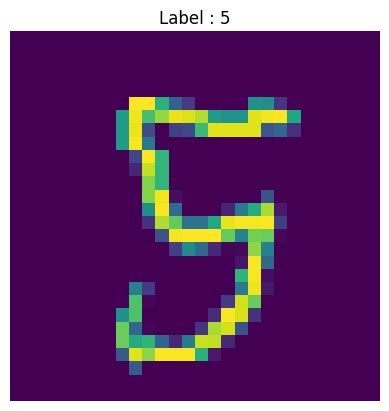

input size :  torch.Size([64, 1, 28, 28])


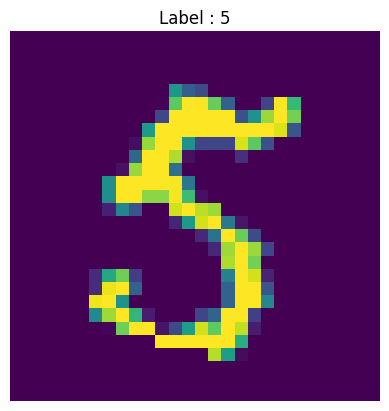

input size :  torch.Size([64, 1, 28, 28])


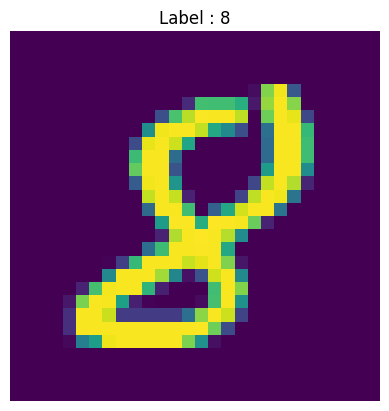

input size :  torch.Size([64, 1, 28, 28])


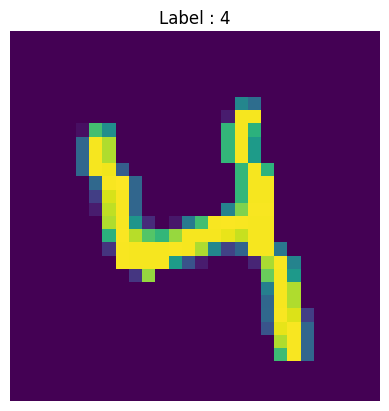

input size :  torch.Size([64, 1, 28, 28])


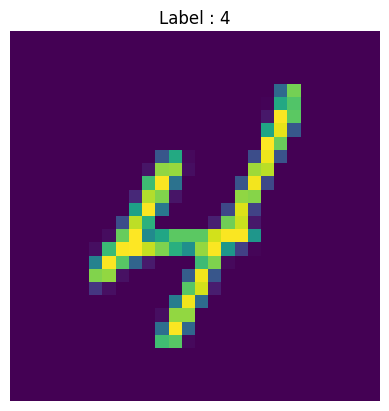

input size :  torch.Size([64, 1, 28, 28])


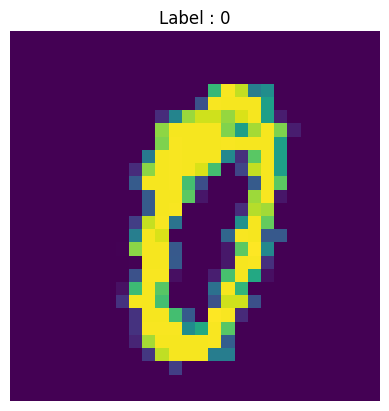

In [ ]:
for idx,(d, l) in enumerate(train_loader):
    print("input size : ", d.size())  

    image = d[0].cpu().squeeze().numpy()  
    plt.imshow(image)
    plt.title(f"Label : {l[0].item()}")
    plt.axis("off")
    plt.show()
    if idx == 5:
        break

## 5.Designing the CNN

In [ ]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(32)   # BatchNorm after conv1
        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2 , stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(64)  

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(128)   
        self.pool = nn.MaxPool2d(kernel_size=2 , stride=2)

        self.fc1 = nn.Linear(128*7*7,128)  # (( width - k + 2*P) / s )    +1  ===>>> 14 > 7
        self.bn_fc1 = nn.BatchNorm1d(128)  
        self.dropout = nn.Dropout(0.5)   ## for overfitting
        self.fc2 = nn.Linear(128,20)
        self.fc3 = nn.Linear(20,10)





    def forward(self, X):

        X = self.pool(F.relu(self.bn1(self.conv1(X))))
        X = F.relu(self.bn2(self.conv2(X)))
        X = self.pool(F.relu(self.bn3(self.conv3(X))))


        X_size = X.size(1) * X.size(2) * X.size(3)
        X = X.view(-1, X_size)




        X = F.relu(self.bn_fc1(self.fc1(X)))
        X = self.dropout(X)
        X = self.fc2(X)
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)



## 6.Saving into Check Points 

In [13]:
def save_checkpoint(model , optimizer , epoch , scheduler,  best_acc):
    check_point = {'epoch' : epoch,
                   'model' : model.state_dict() , 
                   'optimizer' : optimizer.state_dict(), 
                   'scheduler' : scheduler.state_dict() if scheduler  else None , 
                   'best_acc' : best_acc}
    torch.save(check_point, 'CheckPoint.pth')
    print("New checkpoint saved....")
    

## 7.Modeling & Evaluation

In [12]:
model = SimpleCNN().to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)

In [14]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

In [15]:
scheduler = ReduceLROnPlateau(optimizer = optimizer , mode = 'max' , factor = 0.5 , patience = 5)

In [ ]:
epoches = 100
best_acc = 0
train_acc_list = []
val_acc_list = []
for epoch in range(epoches):
    model.train()
    runnining_loss , correct , total = 0.0 , 0 ,0
    for inputs, labels in loaders["train"]:
        inputs , labels = inputs.to(device) , labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        runnining_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    trian_loss = runnining_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_acc_list.append(train_acc) 


    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loaders["val"]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(loaders["val"])
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc) 
    print(
        f"Epoch [{epoch+1}/{epoches}] "
        f"Train Loss: {trian_loss:.4f} | Train Acc: {train_acc:.2f}% \n"
        f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    if val_acc > best_acc:
        best_acc = val_acc
        save_checkpoint(model, optimizer, epoch, scheduler, best_acc)
        
    print("#"*100)


Epoch [1/100] Train Loss: 0.2489 | Train Acc: 94.12% 
| Val Loss: 0.0845 | Val Acc: 97.41%
####################################################################################################
New checkpoint saved....
Epoch [2/100] Train Loss: 0.1021 | Train Acc: 97.02% 
| Val Loss: 0.0625 | Val Acc: 98.14%
####################################################################################################
New checkpoint saved....
Epoch [3/100] Train Loss: 0.0777 | Train Acc: 97.70% 
| Val Loss: 0.0442 | Val Acc: 98.62%
####################################################################################################
New checkpoint saved....
Epoch [4/100] Train Loss: 0.0659 | Train Acc: 97.99% 
| Val Loss: 0.0355 | Val Acc: 98.87%
####################################################################################################
New checkpoint saved....
Epoch [5/100] Train Loss: 0.0619 | Train Acc: 98.14% 
| Val Loss: 0.0389 | Val Acc: 98.76%
#########################################

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epoches+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, epoches+1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def load_check_point(model,file_name='CheckPoint.pth',device="cpu"):
    checkpoint = torch.load(file_name,map_location=device)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    model.eval()
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with best_acc {checkpoint['best_acc']:.2f}%")
    return model

In [ ]:
model = SimpleCNN()
model = load_check_point(model,'CheckPoint.pth',device=device)
predictions = []
with torch.no_grad():
    for data in loaders['test']:
        data = data.to(device)
        outputs = model(data.float())
        _,predicted = torch.max(outputs.data,1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    "ImageId" : range(1,len(predictions)+1),
    "Label"  : predictions
}) 
submission.to_csv("MNist_digits_predictions.csv",index=False)       